# Preloads

In [ ]:
!pip install catboost
!pip install bayesian-optimization
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!kaggle competitions download -c store-sales-time-series-forecasting
!unzip -o store-sales-time-series-forecasting.zip -d store-sales

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 914MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: store-sales/holidays_events.csv  
  inflating: store-sales/oil.csv     
  inflating: store-sales/sample_submission.csv  
  inflating: store-sales/stores.csv  
  inflating: store-sales/test.csv    
  inflating: store-sales/train.csv   
  inflating: store-sales/transactions.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from collections import deque, defaultdict
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import root_mean_squared_log_error
from bayes_opt import BayesianOptimization
import math

from sklearn.linear_model import GammaRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device  )

cuda


In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", '{:.2f}'.format)


In [ ]:
DATA_PATH = 'store-sales/'
data_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]

df = {}
for filename in data_files:
  df_name = filename.split('.')[0]
  df[df_name] = pd.read_csv(os.path.join(DATA_PATH, filename))
  print(f'{filename} loaded')

meta_features = ['date', 'store_nbr', 'id', 'sales', 'family']

sample_submission.csv loaded
transactions.csv loaded
test.csv loaded
stores.csv loaded
oil.csv loaded
train.csv loaded
holidays_events.csv loaded


# Load data

In [ ]:
df['train']['date'] = pd.to_datetime(df['train']['date'])
start_date = df['train'].loc[df['train'].index[0], 'date']
end_date = df['train'].loc[df['train'].index[-1], 'date']
DAYS_TO_PREDICT = 15
end_of_train = end_date - pd.Timedelta(days=DAYS_TO_PREDICT)
start_valid_date = end_of_train + pd.Timedelta(days=1)


all_dates = pd.date_range(start_date, end_date, freq='D')
all_stores = df['train']['store_nbr'].unique()
all_families = df['train']['family'].unique()

full_train = df['train'].copy()
_train = full_train[full_train['date'] <= end_of_train]
_valid = full_train[full_train['date'] > end_of_train]

In [ ]:
discrete_sales_families = []
continuous_sales_families = []
for family, group in _train.groupby('family'):
  if np.allclose(group['sales'], group['sales'].astype('int')):
    discrete_sales_families.append(family)
  else:
    continuous_sales_families.append(family)

print(discrete_sales_families)
print(continuous_sales_families)

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'CELEBRATION', 'CLEANING', 'DAIRY', 'EGGS', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES']
['BREAD/BAKERY', 'DELI', 'FROZEN FOODS', 'GROCERY I', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']


In [ ]:
holidays_events = df['holidays_events'].copy()
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events[
    (holidays_events['type'] != 'Work Day') | (holidays_events['transferred'] == True)
]
holidays_events['type'] = holidays_events['type'].replace({'Bridge': 'Holiday', 'Additional': 'Event', 'Transfer': 'Holiday'})

  In a good way, we need to come up with two more models -
  one predicts oil, the second predicts transactions, but I'll make it easier - I'll fill in the data last year.

In [ ]:
oil_data = df['oil'].copy()
oil_data['date'] = pd.to_datetime(oil_data['date'])
missing_dates = all_dates.difference(oil_data['date'])
full_data = pd.DataFrame({'date': all_dates})
oil_data = (pd
            .merge(full_data, oil_data, on='date', how='left')
            .fillna(method='ffill')
            .fillna(method='bfill')
            .sort_values(by='date')
            .reset_index(drop=True))



last_date = oil_data['date'].max()
target_date = pd.to_datetime("2017-12-26")
extra_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end=target_date, freq="D")


past_dates = extra_dates - pd.DateOffset(years=1)
past_data = oil_data[oil_data['date'].isin(past_dates)][['date', 'dcoilwtico']].copy()

past_data['date'] = past_data['date'] + pd.DateOffset(years=1)


oil_data = pd.concat([oil_data, past_data], ignore_index=True).sort_values('date').reset_index(drop=True)


for period in [1, 7, 15, 30, 365]:
    oil_data[f'oil_lag_{period}'] = oil_data['dcoilwtico'].shift(period)

oil_data['oil_rolling_mean_30'] = oil_data['dcoilwtico'].rolling(window=30, min_periods=1).mean().shift(1)
oil_data['oil_rolling_std_30'] = oil_data['dcoilwtico'].rolling(window=30, min_periods=1).std().shift(1)
oil_data['oil_rolling_mean_15'] = oil_data['dcoilwtico'].rolling(window=15, min_periods=1).mean().shift(1)
oil_data['oil_rolling_std_15'] = oil_data['dcoilwtico'].rolling(window=15, min_periods=1).std().shift(1)
oil_data['oil_rolling_median_7'] = oil_data['dcoilwtico'].rolling(window=7, min_periods=1).median().shift(1)
oil_data['oil_rolling_mean_7'] = oil_data['dcoilwtico'].rolling(window=7, min_periods=1).mean().shift(1)


/tmp/ipython-input-3826997909.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/tmp/ipython-input-3826997909.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


In [ ]:
assert len(extra_dates) == past_data.shape[0], "The number of dates does not match!"


In [ ]:
transactions = df['transactions'].copy()
transactions['date'] = pd.to_datetime(transactions['date'])

full_index = pd.MultiIndex.from_product([all_dates, all_stores], names=['date', 'store_nbr'])
full_data = pd.DataFrame(index=full_index).reset_index()
transactions = pd.merge(full_data, transactions, on=['date', 'store_nbr'], how='left')

transactions['transactions'] = transactions['transactions'].fillna(0)
transactions = transactions.sort_values(['date', 'store_nbr']).reset_index(drop=True)

last_date = transactions['date'].max()
target_date = pd.to_datetime("2017-12-26")
extra_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end=target_date, freq="D")

past_dates = extra_dates - pd.DateOffset(years=1)

past_data = transactions[transactions['date'].isin(past_dates)][['date', 'store_nbr', 'transactions']].copy()

past_data['date'] = past_data['date'] + pd.DateOffset(years=1)

transactions = pd.concat([transactions, past_data], ignore_index=True)

transactions = transactions.drop_duplicates(subset=['date', 'store_nbr']).sort_values(['date', 'store_nbr']).reset_index(drop=True)

assert len(extra_dates) * len(all_stores) == past_data.shape[0], "The number of dates does not match!"

In [ ]:
def make_data(_data, train=True):
  data = _data.copy()
  data['date'] = pd.to_datetime(data['date'])

  # --- filling gaps in train ---
  if train:
    start_date = data['date'].min()
    end_date = data['date'].max()
    all_dates = pd.date_range(start_date, end_date, freq='D')
    missing_dates = all_dates.difference(data['date'])

    full_index = pd.MultiIndex.from_product([all_dates, all_stores, all_families], names=['date', 'store_nbr', 'family'])
    full_data = pd.DataFrame(index=full_index).reset_index()

    data = pd.merge(full_data, data, on=['date', 'store_nbr', 'family'], how='left')
    data[['sales', 'onpromotion']] = data[['sales', 'onpromotion']].fillna(0)


  # --- date features ---
  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['day_of_week'] = data['date'].dt.dayofweek
  day_of_year = data['date'].dt.dayofyear
  for period in [7, 30.5, 365.25]:
      data[f'sin_{period}'] = np.sin(2 * np.pi * day_of_year / period)
      data[f'cos_{period}'] = np.cos(2 * np.pi * day_of_year / period)
  last_day = data['date'].dt.is_month_end
  payday_15 = data['date'].dt.day == 15
  data['is_payday'] = (last_day | payday_15).astype('int')
  data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype('int')
  is_dec_25 = ((data['date'].dt.month == 12) & (data['date'].dt.day == 25))
  is_jan_1 = ((data['date'].dt.month == 1) & (data['date'].dt.day == 1))
  data['is_christmas'] = (is_dec_25 | is_jan_1).astype('int')
  earthquake_date = pd.to_datetime('2016-04-16')
  days_since_eq = (data['date'] - earthquake_date + pd.Timedelta(days=1)).dt.days
  data['earthquake_effect'] = np.where( days_since_eq > 0, np.clip(1 - days_since_eq / 30, 0, 1), 0)


  # --- add lags, rolling stats
  if train:
    grouped_data = data.groupby(['store_nbr', 'family'])
    for period in [1, 7, 15, 30, 365]:
      data[f'sales_lag_{period}'] = grouped_data['sales'].shift(period)

    data[f'sales_rolling_mean_30'] = grouped_data['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean().shift(1))
    data[f'sales_rolling_std_30'] = grouped_data['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).std().shift(1))
    data[f'sales_rolling_mean_15'] = grouped_data['sales'].transform(lambda x: x.rolling(window=15, min_periods=1).mean().shift(1))
    data[f'sales_rolling_std_15'] = grouped_data['sales'].transform(lambda x: x.rolling(window=15, min_periods=1).std().shift(1))
    data[f'sales_rolling_median_7'] = grouped_data['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).median().shift(1))
    data[f'sales_rolling_mean_7'] = grouped_data['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean().shift(1))
  else:
    for period in [1, 7, 15, 30, 365]:
      data[f'sales_lag_{period}'] = np.nan

    data[f'sales_rolling_mean_30'] = np.nan
    data[f'sales_rolling_std_30'] = np.nan
    data[f'sales_rolling_mean_15'] = np.nan
    data[f'sales_rolling_std_15'] = np.nan
    data[f'sales_rolling_median_7'] = np.nan
    data[f'sales_rolling_mean_7'] = np.nan


  # --- add info about stores ---
  data = (pd
          .merge(data, df['stores'], on='store_nbr', how='left')
          .rename(columns={'city': 'store_city', 'state': 'store_state', 'type': 'store_type', 'cluster': 'store_cluster'}))

  # --- add info about holidays ---
  data = pd.merge(data, holidays_events, on='date', how='left')
  data['locale'] = data['locale'].fillna('NONE')
  data['is_holiday'] = (data['type'] == 'Holiday').astype('int')
  data['is_event'] = (data['type'] == 'Event').astype('int')

  data['store_in_event_area'] = 0
  local_holiday_condition = (data['locale'] == 'Local') & (data['store_city'] == data['locale_name'])
  data.loc[local_holiday_condition, 'store_in_event_area'] = 1

  regional_holiday_condition = (data['locale'] == 'Regional') & (data['store_state'] == data['locale_name'])
  data.loc[regional_holiday_condition, 'store_in_event_area'] = 1

  national_holiday_condition = (data['locale'] == 'National')
  data.loc[national_holiday_condition, 'store_in_event_area'] = 1

  data = data.drop(columns=['type', 'locale_name', 'description', 'transferred']).rename(columns={'locale': 'holiday_locale'})


  # --- oil ---
  data = pd.merge(data, oil_data, on='date', how='left')

  # --- transactions ---
  data = pd.merge(data, transactions, on=['date', 'store_nbr'], how='left')


  # --- sort for time order ---
  data = data.sort_values(['date', 'store_nbr', 'family']).reset_index(drop=True)
  cat_features = ['year', 'month', 'day_of_week', 'store_city', 'store_state', 'store_type', 'store_cluster', 'holiday_locale']
  num_features = [col for col in data.columns if col not in meta_features and col not in cat_features]

  data[cat_features] = data[cat_features].astype('category')
  if train:
    discrete_sales_families = []
    continuous_sales_families = []
    for family, group in data.groupby('family'):
      if np.allclose(group['sales'], group['sales'].astype('int')):
        discrete_sales_families.append(family)
    else:
      continuous_sales_families.append(family)


  if train:
    return data, cat_features, num_features
  return data


In [ ]:
full_train, cat_features, num_features = make_data(full_train, train=True)
train, cat_features, num_features  = make_data(_train, train=True)
valid = make_data(_valid, False)

In [ ]:
def get_family_data(data, family):
  return data[data['family'] == family]

# CatBoostFamily

In [ ]:
import os
class CatboostModelsSystem:
  def __init__(self, cat_features, numeric_features, families, model_path=None):
    self.families = families
    self.num_features = numeric_features
    self.cat_features = cat_features
    self.model_path = model_path
    self.families_models = {}

  def _make_train_pool(self, train, fam):
    fam_train = get_family_data(train, fam).copy()
    if fam in ['BABY CARE', 'MAGAZINES']:
        fam_train = fam_train[fam_train['date'] >= '2016-01-01']

    elif fam in ['BOOKS', 'LAWN AND GARDEN']:
          fam_train = fam_train[fam_train['date'] >= '2016-10-08']

    elif fam in ['CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES']:
          fam_train = fam_train[fam_train['date'] >= '2015-06-01']

    elif fam in ['HOME AND KITCHEN I', 'HOME AND KITCHEN II']:
          fam_train = fam_train[fam_train['date'] >= '2015-01-01']

    X = fam_train[self.cat_features + self.num_features]
    y = np.log1p(fam_train['sales'])

    train_pool = Pool(X, y, self.cat_features)
    return train_pool

  def fit(self, train, valid, full_train):
    end_of_train = train['date'].max()
    historic_data = train[(train['date'] <= end_of_train) & (train['date'] >= end_of_train - pd.Timedelta(days=30))]

    for fam in self.families:
      print('FAMILY:', fam)
      train_pool = self._make_train_pool(train, fam)


      self.families_models[fam] = {
          'historic_data': get_family_data(historic_data, fam),
          'is_discrete': fam in discrete_sales_families,
      }


      model_path = None
      if self.model_path is not None:
        fam_name = '-'.join(fam.split('/'))
        model_path = self.model_path + f'{fam_name}_model.cbm'

      if model_path is not None and os.path.exists(model_path):
        model = CatBoostRegressor()
        model.load_model(model_path)
        print('Model is loaded')
      else:
        pbounds = {
          'depth': (4, 10),
          'border_count': (32, 255),
          'iterations': (100, 1000),

          'learning_rate': (0.01, 0.1),
          'l2_leaf_reg': (1, 10),
          'random_strength': (0.0, 8.0),
          'bagging_temperature': (0.0, 1.0),
        }



        def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg, random_strength,
                      bagging_temperature):


          iterations= int(iterations)
          depth = int(depth)
          border_count = int(border_count)

          model = CatBoostRegressor(
                depth=depth,
                border_count=border_count,
                iterations=iterations,

                learning_rate=learning_rate,
                l2_leaf_reg=l2_leaf_reg,
                random_strength=random_strength,
                bagging_temperature=bagging_temperature,
                loss_function='RMSE',
                verbose=0,
                task_type='GPU',
            )

          model.fit(train_pool)
          print('\ntrain score:', model.get_best_score()['learn'])

          self.families_models[fam]['model'] = model
          pred_frame, common_loss = self.predict_family(valid, fam, True, verbose=False)

          return -common_loss #optimize rmsle metric


        optimizer = BayesianOptimization(
            f=objective,
            pbounds=pbounds,
            random_state=42,
        )


        optimizer.maximize(init_points=3, n_iter=7)
        best_params = optimizer.max['params']


        model = CatBoostRegressor(
                depth=int(best_params['depth']),
                border_count=int(best_params['border_count']),
                iterations=int(best_params['iterations']),

                learning_rate=best_params['learning_rate'],
                l2_leaf_reg=best_params['l2_leaf_reg'],
                random_strength=best_params['random_strength'],
                bagging_temperature=best_params['bagging_temperature'],
                loss_function='RMSE',
                verbose=100,
                task_type='GPU',
        )

        train_pool = self._make_train_pool(full_train, fam)
        model.fit(train_pool)
        if self.model_path is not None:
          model.save_model(model_path)



      end_of_train = full_train['date'].max()
      historic_data = full_train[(full_train['date'] <= end_of_train) & (full_train['date'] >= end_of_train - pd.Timedelta(days=30))]

      # put the model
      self.families_models[fam]['historic_data'] = historic_data
      self.families_models[fam]['model'] = model


  def get_family(self, family):
    return self.families_models[family]

  def predict_family(self, data, family, for_validation=True, verbose=True):
    fam = self.get_family(family)
    model = fam['model']
    historic_data = fam['historic_data'].copy()
    is_discrete = fam['is_discrete']

    history = {s: deque(maxlen=30) for s in historic_data['store_nbr'].unique()}

    for _, row in historic_data.iterrows():
        history[row.store_nbr].append(row.sales)

    family_data = data[data['family'] == family].sort_values("date")



    pred_frame = pd.DataFrame({"id": family_data["id"], "sales": np.nan})

    common_loss = 0
    if verbose:
      print(f"\nFAMILY {family}\n")

    for date, daily_data in family_data.groupby("date"):
        features = []

        for _, row in daily_data.iterrows():
            key = row.store_nbr
            hist = history[key]
            arr = np.array(hist)

            feats = {
                "sales_lag_1": arr[-1] if len(arr) >= 1 else np.nan,
                "sales_lag_7": arr[-7] if len(arr) >= 7 else np.nan,
                "sales_rolling_mean_30": arr[-30:].mean() if len(arr) > 0 else np.nan,
                "sales_rolling_std_30": arr[-30:].std() if len(arr) > 0 else np.nan,
                "sales_rolling_mean_15": arr[-15:].mean() if len(arr) > 0 else np.nan,
                "sales_rolling_std_15": arr[-15:].std() if len(arr) > 0 else np.nan,
                "sales_rolling_median_7": np.median(arr[-7:]) if len(arr) > 0 else np.nan,
                "sales_rolling_mean_7": arr[-7:].mean() if len(arr) > 0 else np.nan,
            }
            features.append(feats)

        features_df = pd.DataFrame(features, index=daily_data.index)
        predict_today = daily_data.copy()
        predict_today.update(features_df)


        X = predict_today[self.cat_features + self.num_features]


        y_pred = np.maximum(0, np.expm1(model.predict(X)))

        if is_discrete:
          y_pred = np.round(y_pred)

        for (_, row), pred in zip(predict_today.iterrows(), y_pred):
            history[row.store_nbr].append(pred)



        pred_frame.loc[predict_today.index, "sales"] = y_pred


        if for_validation:
          y_true = np.array(predict_today["sales"])

          loss = root_mean_squared_log_error(y_true, y_pred)

          if verbose:
            print(f"Loss on {date.date()}: {loss}")
          common_loss += loss


    if for_validation:
      common_loss /= family_data["date"].nunique()
      if verbose:
        print(f"\nCommon Loss: {common_loss}")

      return (pred_frame, common_loss)

    return pred_frame


  def predict(self, data, for_validation=True, verbose=True):
    pred_frames = []
    for family in self.families:
      pred_frame = self.predict_family(data, family, for_validation, verbose)
      pred_frames.append(pred_frame)
    return pd.concat(pred_frames).sort_values(by='id').reset_index(drop=True)


catboost_models = CatboostModelsSystem(
    cat_features,
    num_features,
    all_families,
    './',
    )

In [ ]:
catboost_models.fit(train, valid, full_train)

FAMILY: AUTOMOTIVE
Model is loaded
FAMILY: BABY CARE
Model is loaded
FAMILY: BEAUTY
Model is loaded
FAMILY: BEVERAGES
Model is loaded
FAMILY: BOOKS
Model is loaded
FAMILY: BREAD/BAKERY
Model is loaded
FAMILY: CELEBRATION
Model is loaded
FAMILY: CLEANING
Model is loaded
FAMILY: DAIRY
Model is loaded
FAMILY: DELI
Model is loaded
FAMILY: EGGS
Model is loaded
FAMILY: FROZEN FOODS
Model is loaded
FAMILY: GROCERY I
Model is loaded
FAMILY: GROCERY II
Model is loaded
FAMILY: HARDWARE
Model is loaded
FAMILY: HOME AND KITCHEN I
Model is loaded
FAMILY: HOME AND KITCHEN II
Model is loaded
FAMILY: HOME APPLIANCES
Model is loaded
FAMILY: HOME CARE
Model is loaded
FAMILY: LADIESWEAR
Model is loaded
FAMILY: LAWN AND GARDEN
Model is loaded
FAMILY: LINGERIE
Model is loaded
FAMILY: LIQUOR,WINE,BEER
Model is loaded
FAMILY: MAGAZINES
Model is loaded
FAMILY: MEATS
Model is loaded
FAMILY: PERSONAL CARE
Model is loaded
FAMILY: PET SUPPLIES
Model is loaded
FAMILY: PLAYERS AND ELECTRONICS
Model is loaded
FAMILY

In [ ]:
catboost_models.get_family('AUTOMOTIVE')['historic_data'].tail()

,date,store_nbr,family,id,sales,onpromotion,year,month,day_of_week,sin_7,cos_7,sin_30.5,cos_30.5,sin_365.25,cos_365.25,is_payday,is_weekend,is_christmas,earthquake_effect,sales_lag_1,sales_lag_7,sales_lag_15,sales_lag_30,sales_lag_365,sales_rolling_mean_30,sales_rolling_std_30,sales_rolling_mean_15,sales_rolling_std_15,sales_rolling_median_7,sales_rolling_mean_7,store_city,store_state,store_type,store_cluster,holiday_locale,is_holiday,is_event,store_in_event_area,dcoilwtico,oil_lag_1,oil_lag_7,oil_lag_15,oil_lag_30,oil_lag_365,oil_rolling_mean_30,oil_rolling_std_30,oil_rolling_mean_15,oil_rolling_std_15,oil_rolling_median_7,oil_rolling_mean_7,transactions
3059689,2017-08-15,54,POULTRY,3000751.00,59.62,0.00,2017,8,1,0.43,-0.90,0.35,-0.94,-0.69,-0.72,1,0,0,0.00,56.16,73.29,96.94,103.90,20.11,69.01,20.17,68.62,17.39,73.29,68.80,El Carmen,Manabi,C,3,Local,1,0,0,47.57,47.59,49.07,50.21,46.53,45.72,48.27,1.47,49.16,0.61,48.81,48.75,802.00
3059690,2017-08-15,54,PREPARED FOODS,3000752.00,94.00,0.00,2017,8,1,0.43,-0.90,0.35,-0.94,-0.69,-0.72,1,0,0,0.00,147.00,86.00,100.00,50.00,114.00,88.77,29.43,89.73,27.99,86.00,87.29,El Carmen,Manabi,C,3,Local,1,0,0,47.57,47.59,49.07,50.21,46.53,45.72,48.27,1.47,49.16,0.61,48.81,48.75,802.00
3059691,2017-08-15,54,PRODUCE,3000753.00,915.37,76.00,2017,8,1,0.43,-0.90,0.35,-0.94,-0.69,-0.72,1,0,0,0.00,585.62,790.01,633.39,981.71,598.23,687.86,161.92,671.31,174.08,595.18,655.63,El Carmen,Manabi,C,3,Local,1,0,0,47.57,47.59,49.07,50.21,46.53,45.72,48.27,1.47,49.16,0.61,48.81,48.75,802.00
3059692,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,3000754.00,0.00,0.00,2017,8,1,0.43,-0.90,0.35,-0.94,-0.69,-0.72,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,El Carmen,Manabi,C,3,Local,1,0,0,47.57,47.59,49.07,50.21,46.53,45.72,48.27,1.47,49.16,0.61,48.81,48.75,802.00
3059693,2017-08-15,54,SEAFOOD,3000755.00,3.00,0.00,2017,8,1,0.43,-0.90,0.35,-0.94,-0.69,-0.72,1,0,0,0.00,0.00,12.00,4.00,5.00,5.00,2.97,2.61,2.60,3.11,2.00,3.00,El Carmen,Manabi,C,3,Local,1,0,0,47.57,47.59,49.07,50.21,46.53,45.72,48.27,1.47,49.16,0.61,48.81,48.75,802.00


# Predict

In [ ]:
test = make_data(df['test'], train=False)

In [ ]:
test.head()

,id,date,store_nbr,family,onpromotion,year,month,day_of_week,sin_7,cos_7,sin_30.5,cos_30.5,sin_365.25,cos_365.25,is_payday,is_weekend,is_christmas,earthquake_effect,sales_lag_1,sales_lag_7,sales_lag_15,sales_lag_30,sales_lag_365,sales_rolling_mean_30,sales_rolling_std_30,sales_rolling_mean_15,sales_rolling_std_15,sales_rolling_median_7,sales_rolling_mean_7,store_city,store_state,store_type,store_cluster,holiday_locale,is_holiday,is_event,store_in_event_area,dcoilwtico,oil_lag_1,oil_lag_7,oil_lag_15,oil_lag_30,oil_lag_365,oil_rolling_mean_30,oil_rolling_std_30,oil_rolling_mean_15,oil_rolling_std_15,oil_rolling_median_7,oil_rolling_mean_7,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,2,-0.43,-0.90,0.15,-0.99,-0.70,-0.71,0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NONE,0,0,0,46.57,47.57,49.59,49.19,46.02,46.57,48.31,1.44,48.98,0.67,48.81,48.53,1648.00
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,2,-0.43,-0.90,0.15,-0.99,-0.70,-0.71,0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NONE,0,0,0,46.57,47.57,49.59,49.19,46.02,46.57,48.31,1.44,48.98,0.67,48.81,48.53,1648.00
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,2,-0.43,-0.90,0.15,-0.99,-0.70,-0.71,0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NONE,0,0,0,46.57,47.57,49.59,49.19,46.02,46.57,48.31,1.44,48.98,0.67,48.81,48.53,1648.00
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,2,-0.43,-0.90,0.15,-0.99,-0.70,-0.71,0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NONE,0,0,0,46.57,47.57,49.59,49.19,46.02,46.57,48.31,1.44,48.98,0.67,48.81,48.53,1648.00
4,3000892,2017-08-16,1,BOOKS,0,2017,8,2,-0.43,-0.90,0.15,-0.99,-0.70,-0.71,0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,NONE,0,0,0,46.57,47.57,49.59,49.19,46.02,46.57,48.31,1.44,48.98,0.67,48.81,48.53,1648.00


In [ ]:
pred_frame = catboost_models.predict(test, for_validation=False, verbose=False)

In [ ]:
pred_frame.to_csv('submission.csv', index=False)

# some experiments

In [ ]:
class FamiliesModelsSystem:
  def __init__(self, historic_data, cat_features, numeric_features, families, historic_period=30):
    self.historic_period = historic_period
    self.families = families
    self.numeric_features = numeric_features
    self.cat_features = cat_features
    self.families_models = {}
    self.historic_data = historic_data

    for fam in self.families:
      self.families_models[fam] = {
          'historic_data': self.historic_data[self.historic_data['family'] == fam].copy(),
          'model': None,
          'input_func': None,
          'output_func': None,
          'predict_params': {},
          'is_discrete': fam in discrete_sales_families,
      }


  def get_family(self, family):
    return self.families_models[family]

  def set_family(self, family, model=None, input_func=None, output_func=None, historic_data=None, predict_params={}):
    if historic_data is not None:
      self.families_models[family]['historic_data'] = historic_data

    if model is not None:
      self.families_models[family]['model'] = model

    if predict_params is not None:
      self.families_models[family]['predict_params'] = predict_params

    if input_func is not None:
      self.families_models[family]['input_func'] = input_func

    if output_func is not None:
      self.families_models[family]['output_func'] = output_func



  def predict_family(self, data, family, for_validation=True, verbose=True):
    fam = self.get_family(family)
    historic_data = fam['historic_data'].copy()
    model = fam['model']
    input_func = fam['input_func']
    output_func = fam['output_func']
    predict_params = fam['predict_params']
    is_discrete = fam['is_discrete']

    history = {s: deque(maxlen=self.historic_period) for s in historic_data['store_nbr'].unique()}

    for _, row in historic_data.iterrows():
        history[row.store_nbr].append(row.sales)

    family_data = data[data['family'] == family].sort_values("date")
    pred_frame = pd.DataFrame({"id": family_data["id"], "sales": np.nan})

    common_loss = 0
    if verbose:
      print(f"\nFAMILY {family}\n")

    for date, daily_data in family_data.groupby("date"):
        features = []

        for _, row in daily_data.iterrows():
            key = row.store_nbr
            hist = history[key]
            arr = np.array(hist)

            feats = {
                "sales_lag_1": arr[-1] if len(arr) >= 1 else np.nan,
                "sales_lag_7": arr[-7] if len(arr) >= 7 else np.nan,
                "sales_rolling_mean_30": arr[-30:].mean() if len(arr) > 0 else np.nan,
                "sales_rolling_std_30": arr[-30:].std() if len(arr) > 0 else np.nan,
                "sales_rolling_mean_15": arr[-15:].mean() if len(arr) > 0 else np.nan,
                "sales_rolling_std_15": arr[-15:].std() if len(arr) > 0 else np.nan,
                "sales_rolling_median_7": np.median(arr[-7:]) if len(arr) > 0 else np.nan,
                "sales_rolling_mean_7": arr[-7:].mean() if len(arr) > 0 else np.nan,
            }
            features.append(feats)

        features_df = pd.DataFrame(features, index=daily_data.index)
        predict_today = daily_data.copy()
        predict_today.update(features_df)


        X = input_func(predict_today)


        y_pred = np.maximum(0, output_func(model.predict(X, **predict_params)))

        if is_discrete:
          y_pred = np.round(y_pred)

        for (_, row), pred in zip(predict_today.iterrows(), y_pred):
            history[row.store_nbr].append(pred)

        if for_validation:
          y_true = np.array(predict_today["sales"])

          loss = root_mean_squared_log_error(y_true, y_pred)
          pred_frame.loc[predict_today.index, "sales"] = y_pred

          if verbose:
            print(f"Loss on {date.date()}: {loss}")
          common_loss += loss


    if for_validation:
      common_loss /= family_data["date"].nunique()
      if verbose:
        print(f"\nCommon Loss: {common_loss}")

      return (pred_frame, common_loss)

    return pred_frame


  def predict(self, data):
    pred_frames = []
    for family in self.families:
      pred_frames.append(self.predict_family(data, family))
    return pd.concat(pred_frames).sort_values(by='id').reset_index(drop=True)


families_models = FamiliesModelsSystem(
    train[(train['date'] >= end_of_train - pd.Timedelta(days=30)) & (train['date'] <= end_of_train)],
    cat_features,
    num_features,
    all_families,
    30
    )

## AUTOMOTIVE

## Main

In [ ]:
automotive_train = get_family_data(train, 'AUTOMOTIVE')
automotive_valid = get_family_data(valid, 'AUTOMOTIVE')

In [ ]:
def prepare_input_func_2(df):
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
  encoded_features = ohe.fit_transform(df[cat_features])
  encoded_feature_names = ohe.get_feature_names_out(cat_features)
  X = df[num_features]
  cat_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)
  X = pd.concat([X, cat_df], axis=1).fillna(0)


  corr_matrix = X.corr()
  corr_pairs = corr_matrix.unstack()

  corr_pairs = corr_pairs.drop_duplicates().dropna()
  corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

  corr_sorted = corr_pairs.abs().sort_values(ascending=False)

  strong_corr = corr_pairs[corr_pairs.abs() > 0.8].sort_values(ascending=False)
  corr_pairs = strong_corr.index.tolist()
  linear_features = set(X.columns)
  variances = X.var()


  for feat1, feat2 in corr_pairs:
    if feat1 in linear_features and feat2 in linear_features:
      if variances[feat1] >= variances[feat2]:
        linear_features.remove(feat2)
      else:
        linear_features.remove(feat1)


  linear_features = list(linear_features)
  X = X[linear_features]


  linear_features = X.columns
  linear_num_features = list(set(linear_features) - set(encoded_feature_names))

  def input_func_2(df):
    encoded_features = ohe.fit_transform(df[cat_features])
    encoded_feature_names = ohe.get_feature_names_out(cat_features)
    _df = df[linear_num_features]
    cat_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
    _df = pd.concat([_df, cat_df], axis=1).fillna(0)



    X = pd.DataFrame()
    for feat in linear_features:
      if feat in _df.columns:
        X[feat] = _df[feat]
      else:
        X[feat] = pd.Series(0, index=_df.index)

    return X

  return (input_func_2, linear_num_features, encoded_feature_names)

In [ ]:

def prepare_input_func_3(df):
  num_df = df[num_features]
  cat_df = df[cat_features]


  corr_matrix = num_df.corr()
  corr_pairs = corr_matrix.unstack()

  corr_pairs = corr_pairs.drop_duplicates().dropna()
  corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

  corr_sorted = corr_pairs.abs().sort_values(ascending=False)

  strong_corr = corr_pairs[corr_pairs.abs() > 0.8].sort_values(ascending=False)
  corr_pairs = strong_corr.index.tolist()
  linear_features = set(num_df.columns)
  variances = num_df.var()


  for feat1, feat2 in corr_pairs:
    if feat1 in linear_features and feat2 in linear_features:
      if variances[feat1] >= variances[feat2]:
        linear_features.remove(feat2)
      else:
        linear_features.remove(feat1)


  linear_features = list(linear_features)

  def input_func_3(df):
    return df[linear_features + cat_features]

  return input_func_3


In [ ]:
def prepare_input_func_4(df):
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
  encoded_features = ohe.fit_transform(df[cat_features])
  encoded_feature_names = ohe.get_feature_names_out(cat_features)
  X = df[num_features]
  cat_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)
  X = pd.concat([X, cat_df], axis=1)
  features = X.columns


  def input_func_4(df):
    encoded_features = ohe.fit_transform(df[cat_features])
    encoded_feature_names = ohe.get_feature_names_out(cat_features)
    _df = df[num_features].copy()
    cat_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
    _df = pd.concat([_df, cat_df], axis=1)



    list_of_dfs = []
    for feat in features:
      if feat not in _df.columns:
        _df[feat] = 0
      list_of_dfs.append(_df[[feat]])
    return pd.concat(list_of_dfs, axis=1)


  return input_func_4

In [ ]:
def input_func_1(df):
  return df[num_features + cat_features] # simple preprocess (fits for catboost/lightgbm for example)
input_func_2, linear_num_features, encoded_feature_names = prepare_input_func_2(automotive_train) # ohe + remove multicollinearity
input_func_3 = prepare_input_func_3(automotive_train) # remove multicollinearity
input_func_4 = prepare_input_func_4(automotive_train) # ohe

def input_func_5(df):
  return  torch.tensor(input_func_2(df).to_numpy(), dtype=torch.float32).to(device)

In [ ]:
def output_func_1(y, df=None): # for working with y_log
  return np.expm1(np.clip(y, -np.inf, 709))
def output_func_2(y, df=None): # for gamma
  return np.array(y) - 1

def output_func_3(y, df=None): #just target
  return np.array(y)

In [ ]:
y = np.array(automotive_train['sales'])
y_log = np.log1p(automotive_train['sales'])
y_tensor = torch.tensor(np.array(y),  dtype=torch.float32).to(device)
X_1 = input_func_1(automotive_train)
X_2 = input_func_2(automotive_train)
X_3 = input_func_3(automotive_train)
X_4 = input_func_4(automotive_train)
X_5 = input_func_5(automotive_train)

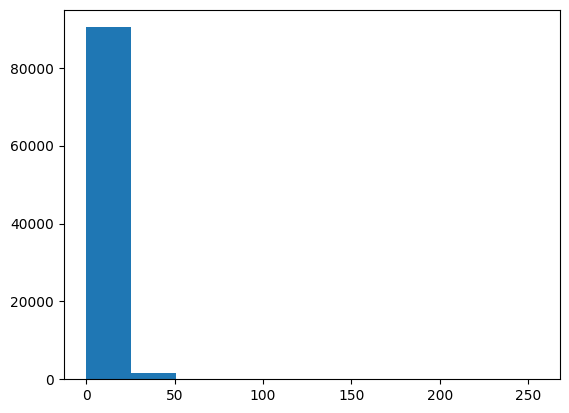

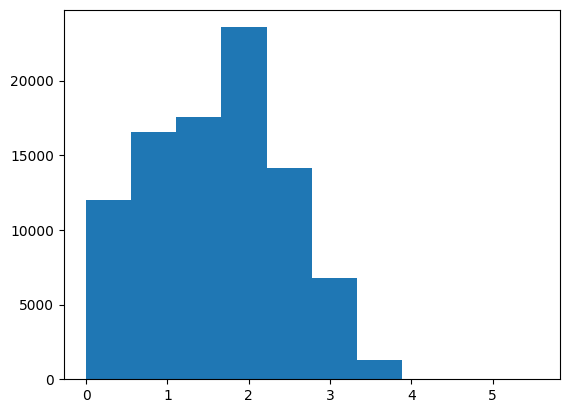

In [ ]:
plt.hist(y)
plt.show()
plt.hist(y_log)
plt.show()

## Gamma Regressor

In [ ]:
from sklearn.linear_model import GammaRegressor
model = GammaRegressor(alpha=2.0, fit_intercept=True, max_iter =2000, verbose=500)
model.fit(X_2, y + 1)
families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_2, output_func=output_func_2)
_ = families_models.predict_family(valid, 'AUTOMOTIVE', True, True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.6204911596668764
Loss on 2017-08-02: 0.5991919770224481
Loss on 2017-08-03: 0.5580627611667507
Loss on 2017-08-04: 0.6019643693988888
Loss on 2017-08-05: 0.5843635895979518
Loss on 2017-08-06: 0.6057707603502303
Loss on 2017-08-07: 0.6034971411184565
Loss on 2017-08-08: 0.5821938905476199
Loss on 2017-08-09: 0.5887554829606841
Loss on 2017-08-10: 0.5413358480219108
Loss on 2017-08-11: 0.6247682705474564
Loss on 2017-08-12: 0.6342916033866437
Loss on 2017-08-13: 0.7671376172707637
Loss on 2017-08-14: 0.6767066637029295
Loss on 2017-08-15: 0.79192196601114

Common Loss: 0.6253635400513834


## Catboost

### RMSE

In [ ]:
pbounds = {
    'depth': (4, 10),
    'border_count': (32, 255),
    'iterations': (100, 1000),

    'learning_rate': (0.01, 0.1),
    'l2_leaf_reg': (1, 10),
    'random_strength': (0.0, 8.0),
    'bagging_temperature': (0.0, 1.0),
}


def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg, random_strength,
              bagging_temperature):


  iterations= int(iterations)
  depth = int(depth)
  border_count = int(border_count)

  model = CatBoostRegressor(
        depth=depth,
        border_count=border_count,
        iterations=iterations,

        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        loss_function='RMSE',
        verbose=0,
        task_type='GPU',
    )

  model.fit(train_pool)
  print('\ntrain score:', model.get_best_score()['learn'])

  families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_1, output_func=output_func_1)
  pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

  return -common_loss #optimize rmsle metric


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)


optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | random... | baggin... |
-------------------------------------------------------------------------------------------------------------

train score: {'RMSE': 0.49048649602617406}
| 1         | -0.510971 | 6.2472407 | 244.00929 | 758.79454 | 0.0638792 | 2.4041677 | 1.2479561 | 0.0580836 |

train score: {'RMSE': 0.5083128141935075}
| 2         | -0.517176 | 9.1970568 | 166.04864 | 737.26532 | 0.0118526 | 9.7291886 | 6.6595411 | 0.2123391 |

train score: {'RMSE': 0.5077139570181322}
| 3         | -0.512480 | 5.0909498 | 72.899205 | 373.81801 | 0.0572280 | 4.8875051 | 2.3298331 | 0.6118528 |

train score: {'RMSE': 0.5101637168959184}
| 4         | -0.517401 | 4.8369631 | 97.148256 | 429.72565 | 0.0510462 | 8.0665836 | 1.5973902 | 0.5142344 |

train score: {'RMSE': 0.5056911712567718}
| 5         | -0.519506 | 7.5544874 | 42.358442 | 646.79036 | 0.0253471 | 1.5854643 | 7.5910842 | 0.9656320 |

train score: 

### Huber

In [ ]:
train_pool = Pool(X_1, y_log, cat_features)

In [ ]:
mad = np.median(np.abs(y - np.median(y)))
sigma_hat = 1.4826 * mad

CatBoost with Huber loss is prone to overfitting

In [ ]:
pbounds = {
    'depth': (2, 4),
    'border_count': (32, 64),
    'iterations': (100, 500),


    'lr_log': (-2.0, -1.0),
    'l2_leaf_reg': (1000, 600),
    'bagging_temperature': (0.0, 5.0),
    'random_strength': (2.0, 5.0),


    'alpha': (1, 2),

}


def objective(depth, border_count, iterations, lr_log, l2_leaf_reg,
              bagging_temperature, random_strength, alpha):


  depth = int(depth)
  border_count = int(border_count)
  iterations = int(iterations)
  learning_rate = 10 ** lr_log

  model = CatBoostRegressor(
        depth=depth,
        iterations=iterations,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        random_strength=random_strength,
        loss_function=f'Huber:delta={alpha * sigma_hat}',
        verbose=0,
        task_type='GPU',
    )

  model.fit(train_pool)
  print("\nBest train score:", model.get_best_score()['learn'])
  families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_1, output_func=output_func_1, predict_params={})
  _, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)
  # best_valid_score = float('inf')
  # best_iter = None

  # for i in range(50, model.tree_count_, 50):
  #   families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_1, output_func=output_func_1, predict_params={'ntree_end': i})
  #   pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)
  #   if common_loss < best_valid_score:
  #     best_valid_score = common_loss
  #     best_iter = i

  # print('Best iter', best_iter)
  return -common_loss #optimize rmsle metric


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)


optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | baggin... | random... |   alpha   |
-------------------------------------------------------------------------------------------------------------------------

Best train score: {'Huber:delta=20.453334783533272': 0.2750424082370414}
| 1         | -0.888799 | 2.3745401 | 62.422857 | 39.279757 | 0.0339463 | 120.20838 | 2.4679835 | 2.1742508 | 4.5985284 |

Best train score: {'Huber:delta=11.34283973677831': 0.7476955556099578}
| 2         | -1.402403 | 2.6011150 | 54.658322 | 10.823379 | 0.0487963 | 424.59918 | 2.6370173 | 2.5454749 | 2.5502135 |

Best train score: {'Huber:delta=13.784112619805045': 0.6541253379738434}
| 3         | -1.356872 | 2.3042422 | 48.792205 | 27.277800 | 0.0216491 | 325.33380 | 2.4184815 | 2.8764339 | 3.0990855 |

Best train score: {'Huber:delta=11.170971592009007': 0.7191743373808591}
| 4         | -1.375798 | 2.4560699 | 57.125630 | 17.986951 | 0.0305693 | 316.58655 | 2.1393512

KeyboardInterrupt: 

In [ ]:
pbounds = {
    'depth': (4, 10),
    'border_count': (32, 255),


    'learning_rate': (0.03, 0.1),
    'l2_leaf_reg': (1, 10),
    'bagging_temperature': (0.0, 1.0),


    'alpha': (0.5, 2.0),
}


mad = np.median(np.abs(y - np.median(y)))
sigma_hat = 1.4826 * mad


def objective(depth, border_count, learning_rate, l2_leaf_reg,
              bagging_temperature, alpha):


  depth = int(depth)
  border_count = int(border_count)

  model = CatBoostRegressor(
        depth=depth,
        iterations=2000,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        border_count=border_count,
        loss_function=f'Huber:delta={alpha * sigma_hat}',
        verbose=0,
        task_type='GPU',
    )

  model.fit(train_pool, early_stopping_rounds=50)

  families_models.set_family('AUTOMOTIVE', model=model)
  # print('\nPARAMS:')
  # print(families_models.get_family('AUTOMOTIVE')['model'].get_params())
  pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

  return -common_loss #optimize rmsle metric


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)


optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |   depth   | border... | learni... | l2_lea... | baggin... |   alpha   |
-------------------------------------------------------------------------------------------------
| 1         | -0.508439 | 6.2472407 | 244.00929 | 0.0812395 | 6.3879263 | 0.1560186 | 0.7339917 |
| 2         | -0.514879 | 4.3485016 | 225.15728 | 0.0720780 | 7.3726532 | 0.0205844 | 1.9548647 |
| 3         | -0.508864 | 8.9946558 | 79.351621 | 0.0427277 | 2.6506405 | 0.3042422 | 1.2871346 |
| 4         | -0.507627 | 6.5916701 | 96.944098 | 0.0728297 | 2.2554447 | 0.2921446 | 1.0495427 |
| 5         | -0.515701 | 6.7364199 | 207.09423 | 0.0439771 | 5.6281099 | 0.5924145 | 0.5696756 |
| 6         | -0.520521 | 9.1130890 | 121.62341 | 0.0637458 | 9.9336292 | 0.4956881 | 1.4157312 |
| 7         | -0.509282 | 4.0       | 88.969716 | 0.1       | 10.0      | 1.0       | 2.0       |
| 8         | -0.506165 | 5.0983817 | 97.085529 | 0.0781746 | 3.5559340 | 0.6756173 | 0.9930018 |
| 9         | -0.505

In [ ]:
model_1 = CatBoostRegressor(
    depth=1,
    iterations=2000,
    learning_rate=0.01,
    l2_leaf_reg=50,
    bagging_temperature=0,
    border_count=96,
    loss_function=f'Huber:delta={0.5 * sigma_hat}',
    verbose=100,
    task_type='GPU',
)


model_1.fit(train_pool)

0:	learn: 1.6076632	total: 13.5ms	remaining: 27s
100:	learn: 0.3792730	total: 885ms	remaining: 16.6s
200:	learn: 0.2067158	total: 1.49s	remaining: 13.3s
300:	learn: 0.1693709	total: 1.76s	remaining: 9.96s
400:	learn: 0.1560493	total: 2s	remaining: 8s
500:	learn: 0.1496215	total: 2.27s	remaining: 6.8s
600:	learn: 0.1461245	total: 2.49s	remaining: 5.79s
700:	learn: 0.1439572	total: 2.71s	remaining: 5.01s
800:	learn: 0.1425057	total: 2.91s	remaining: 4.36s
900:	learn: 0.1414943	total: 3.15s	remaining: 3.84s
1000:	learn: 0.1407485	total: 3.36s	remaining: 3.35s
1100:	learn: 0.1401990	total: 3.57s	remaining: 2.91s
1200:	learn: 0.1397756	total: 3.77s	remaining: 2.51s
1300:	learn: 0.1394364	total: 3.99s	remaining: 2.14s
1400:	learn: 0.1391551	total: 4.22s	remaining: 1.8s
1500:	learn: 0.1389133	total: 4.43s	remaining: 1.47s
1600:	learn: 0.1387006	total: 4.64s	remaining: 1.16s
1700:	learn: 0.1385114	total: 4.84s	remaining: 852ms
1800:	learn: 0.1383422	total: 5.06s	remaining: 559ms
1900:	learn: 0

In [ ]:
families_models.set_family('AUTOMOTIVE', model=model_1, input_func=input_func_1, output_func=output_func_1)
pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.5496756500556205
Loss on 2017-08-02: 0.5565513347003225
Loss on 2017-08-03: 0.5390836947969766
Loss on 2017-08-04: 0.6199470109944155
Loss on 2017-08-05: 0.4563432476559968
Loss on 2017-08-06: 0.4700667445994126
Loss on 2017-08-07: 0.49894585951996806
Loss on 2017-08-08: 0.5493815754188087
Loss on 2017-08-09: 0.4553798781715263
Loss on 2017-08-10: 0.4947861674112539
Loss on 2017-08-11: 0.6494766038066936
Loss on 2017-08-12: 0.47714196917184043
Loss on 2017-08-13: 0.6083143304731341
Loss on 2017-08-14: 0.49075998882709765
Loss on 2017-08-15: 0.5383207437548301

Common Loss: 0.5302783199571931


The distribution of the logarithmic target looks like normal, but Huber Loss does not help, you can optimize RMSE directly.
I tried to make the model simpler, but even at 100 iterations with trees of depth 2 and l2_leaf_reg 500, the model already had a learn score of 0.13

### Tweedie (gamma)

In [ ]:
train_pool = Pool(X_1, y + 1, cat_features)

In [ ]:
pbounds = {
    'depth': (3, 5),
    'border_count': (64, 128),
    'iterations': (1000, 3000),
    'learning_rate': (0.01, 0.03),
    'l2_leaf_reg': (50, 200),
    'random_strength': (1.0, 5.0),
    'bagging_temperature': (1.0, 2.0),
    'variance_power': (1.5, 1.7)
}



def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg, random_strength,
              bagging_temperature, variance_power):

    iterations = int(iterations)
    depth = int(depth)
    border_count = int(border_count)

    model = CatBoostRegressor(
        depth=depth,
        border_count=border_count,
        iterations=iterations,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        loss_function=f'Tweedie:variance_power={variance_power}',  # Gamma
        verbose=0,
        task_type='GPU',
    )

    model.fit(train_pool)
    print('\ntrain score:', model.get_best_score()['learn'])

    families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_1, output_func=output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | random... | baggin... | varian... |
-------------------------------------------------------------------------------------------------------------------------

train score: {'Tweedie:variance_power=1.673235229154987': 13.592502828915872}
| 1         | -1.974962 | 3.7490802 | 124.84571 | 2463.9878 | 0.0219731 | 73.402796 | 1.6239780 | 1.0580836 | 1.6732352 |

train score: {'Tweedie:variance_power=1.5366809019706869': 15.350347630238934}
| 2         | -1.961437 | 4.2022300 | 109.31664 | 1041.1689 | 0.0293981 | 174.86639 | 1.8493564 | 1.1818249 | 1.5366809 |

train score: {'Tweedie:variance_power=1.5732723686587384': 14.71188579884232}
| 3         | -1.970208 | 3.6084844 | 97.584411 | 1863.8900 | 0.0158245 | 141.77793 | 1.5579754 | 1.2921446 | 1.5732723 |

train score: {'Tweedie:variance_power=1.5341048247374582': 15.420750913957436}
| 4         | -1.988952 | 3.9121399 | 114.25126 | 1399.3475 | 0.0202846 

KeyboardInterrupt: 

### models

In [ ]:
train_pool = Pool(X_1, y_log, cat_features)
catboost_model = CatBoostRegressor(
    iterations=996,
    border_count=227,
    depth=9,
    learning_rate=0.0429257,
    l2_leaf_reg=8.3054692,
    random_strength=1.2160092,
    bagging_temperature=0.9713499,
    # task_type='GPU',
    loss_function='RMSE',
    )

catboost_model.fit(train_pool, verbose=500)

0:	learn: 0.8629125	total: 697ms	remaining: 11m 33s
500:	learn: 0.4932873	total: 3m 25s	remaining: 3m 22s
995:	learn: 0.4759069	total: 6m 19s	remaining: 0us


## XGBoost

In [ ]:
from xgboost import XGBRegressor

### RMSLE

In [ ]:
pbounds = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'min_child_weight': (1, 10),
    'gamma': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 512),
    'scale_pos_weight': (1, 5),
    'n_estimators': (500, 5000)
}


def objective(learning_rate, max_depth, min_child_weight, gamma,
              subsample, colsample_bytree, reg_alpha, reg_lambda, max_bin,
              scale_pos_weight, n_estimators):

  model = XGBRegressor(
    objective='reg:squaredlogerror',
    n_estimators=int(n_estimators),
    learning_rate=learning_rate,
    tree_method='gpu_hist',
    enable_categorical=True,
    max_depth=int(max_depth),
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    max_bin=int(max_bin),
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
  )

  model.fit(X_1, y, verbose=False)

  families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_1, output_func=output_func_3)
  _, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

  return -common_loss #optimize rmsle metric


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)


optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']

|   iter    |  target   | learni... | max_depth | min_ch... |   gamma   | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | scale_... | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.525749 | 0.0811626 | 11.605714 | 7.5879454 | 2.9932924 | 0.5780093 | 0.5779972 | 0.5808361 | 8.6617614 | 333.29952 | 3.8322903 | 592.63022 |
| 2         | -0.520139 | 0.1942828 | 10.659541 | 2.9110519 | 0.9091248 | 0.5917022 | 0.6521211 | 5.2475643 | 4.3194501 | 194.47065 | 3.4474115 | 1127.7223 |
| 3         | -0.527881 | 0.0655074 | 6.9308947 | 5.1046298 | 3.9258798 | 0.5998368 | 0.7571172 | 5.9241456 | 0.4645041 | 336.18009 | 1.6820964 | 792.73216 |
| 4         | -0.521551 | 0.1902882 | 11.725056 | 8.2755761 | 1.5230688 | 0.5488360 | 0.8421165 | 4.4015249 | 1.2203823 | 285.83925 | 1.1375540 | 4591.9418 |
| 5         | -0.526100 | 0.0591681 | 9.3001782 | 3.

### Gamma

In [ ]:
pbounds = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'min_child_weight': (1, 10),
    'gamma': (0, 5),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 512),
    'scale_pos_weight': (1, 5),
    'n_estimators': (500, 5000)
}

def objective(learning_rate, max_depth, min_child_weight, gamma,
              subsample, colsample_bytree, reg_alpha, reg_lambda, max_bin,
              scale_pos_weight, n_estimators):

    model = XGBRegressor( # without enable_cat cause of ohe
        objective='reg:gamma',
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        tree_method='gpu_hist',
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        max_bin=int(max_bin),
        scale_pos_weight=scale_pos_weight,
        verbosity=0,
        predictor='gpu_predictor'
    )

    model.fit(
        X_4, y+1,
        verbose=False,
    )

    families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_4, output_func=output_func_2)
    _, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']
print(best_params)


|   iter    |  target   | learni... | max_depth | min_ch... |   gamma   | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | scale_... | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.522582 | 0.0811626 | 11.605714 | 7.5879454 | 2.9932924 | 0.5780093 | 0.5779972 | 0.5808361 | 8.6617614 | 333.29952 | 3.8322903 | 592.63022 |
| 2         | -0.539151 | 0.1942828 | 10.659541 | 2.9110519 | 0.9091248 | 0.5917022 | 0.6521211 | 5.2475643 | 4.3194501 | 194.47065 | 3.4474115 | 1127.7223 |
| 3         | -0.510634 | 0.0655074 | 6.9308947 | 5.1046298 | 3.9258798 | 0.5998368 | 0.7571172 | 5.9241456 | 0.4645041 | 336.18009 | 1.6820964 | 792.73216 |
| 4         | -0.514569 | 0.1902882 | 11.725056 | 8.2755761 | 1.5230688 | 0.5488360 | 0.8421165 | 4.4015249 | 1.2203823 | 285.83925 | 1.1375540 | 4591.9418 |
| 5         | -0.515659 | 0.0591681 | 9.3001782 | 3.

### models

In [ ]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [ ]:
xgboost_model = XGBRegressor(
        objective='reg:gamma',
        n_estimators=3538,
        learning_rate=0.0606537,
        tree_method='hist',
        max_depth=8,
        min_child_weight=5.1085874,
        gamma=3.8861886,
        subsample=0.5745213,
        colsample_bytree=0.7286591,
        reg_alpha=5.3854684,
        reg_lambda=7.5315923,
        max_bin=333,
        scale_pos_weight=2.4328256 ,
        device="cuda",
)

xgboost_model.fit(X=X_4, y=y+1)

families_models.set_family('AUTOMOTIVE', model=xgboost_model, input_func=input_func_4, output_func=output_func_2)
xgboost_pred_frame, _ = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.548135025992128
Loss on 2017-08-02: 0.5322290996728101
Loss on 2017-08-03: 0.532047322141564
Loss on 2017-08-04: 0.5626479193680096
Loss on 2017-08-05: 0.4314828740464766
Loss on 2017-08-06: 0.41098183587445253
Loss on 2017-08-07: 0.48576675596400837
Loss on 2017-08-08: 0.5415334805459774
Loss on 2017-08-09: 0.44543473658931176
Loss on 2017-08-10: 0.47538016918746506
Loss on 2017-08-11: 0.5327368341377836
Loss on 2017-08-12: 0.5227738255906444
Loss on 2017-08-13: 0.5778687182768394
Loss on 2017-08-14: 0.5378133567048226
Loss on 2017-08-15: 0.5009245509337512

Common Loss: 0.5091837670017364


## LightGBM

In [ ]:
import lightgbm as lgb

### RMSE

In [ ]:
pbounds_lgb = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'num_leaves': (16, 256),
    'min_child_samples': (5, 50),
    'min_child_weight': (1e-3, 10.0),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 255),
    'n_estimators': (500, 2000)
}

def objective(learning_rate, max_depth, num_leaves, min_child_samples,
              min_child_weight, subsample, colsample_bytree,
              reg_alpha, reg_lambda, max_bin, n_estimators):

    train_pool = lgb.Dataset(X_1, label=y_log, categorical_feature=cat_features)

    max_depth = int(max_depth)
    num_leaves = int(num_leaves)
    min_child_samples = int(min_child_samples)
    max_bin = int(max_bin)
    n_estimators = int(n_estimators)


    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'min_child_samples': min_child_samples,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_bin': max_bin,
        'metric': 'rmse',
        'device': 'gpu',
        'verbose': -1
    }




    callbacks = [lgb.log_evaluation(period=n_estimators)]

    model = lgb.train(
        params,
        train_pool,
        num_boost_round=n_estimators,
        valid_sets=[train_pool],
        callbacks=callbacks
    )


    families_models.set_family('AUTOMOTIVE', model, input_func_1, output_func_1)
    pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds_lgb,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   | learni... | max_depth | num_le... | min_ch... | min_ch... | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[530]	training's rmse: 0.360314
| 1         | -0.523502 | 0.0811626 | 11.605714 | 191.67854 | 31.939631 | 1.5610303 | 0.5779972 | 0.5290418 | 8.6617614 | 6.0111501 | 199.24186 | 530.87674 |
[709]	training's rmse: 0.318923
| 2         | -0.531266 | 0.1942828 | 10.659541 | 66.961386 | 13.182123 | 1.8348616 | 0.6521211 | 0.7623782 | 4.3194501 | 2.9122914 | 180.86390 | 709.24079 |
[597]	training's rmse: 0.45297
| 3         | -0.515164 | 0.0655074 | 6.9308947 | 125.45679 | 40.332918 | 1.9975381 | 0.7571172 | 0.7962072 | 0.4645041 | 6.0754485 | 96.570107 | 597.57738 |
[1863]	training's rmse: 0.043395
| 4         | -0.531844 | 0.1902882 | 11.725056 | 210.01536 | 18.707619 | 0.977623

### Gamma

In [ ]:
pbounds_lgb = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'num_leaves': (16, 256),
    'min_child_samples': (5, 50),
    'min_child_weight': (1e-3, 10.0),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 255),
    'n_estimators': (500, 2000)
}

def objective(learning_rate, max_depth, num_leaves, min_child_samples,
              min_child_weight, subsample, colsample_bytree,
              reg_alpha, reg_lambda, max_bin, n_estimators):

    train_pool = lgb.Dataset(X_1, label=y + 1, categorical_feature=cat_features)

    max_depth = int(max_depth)
    num_leaves = int(num_leaves)
    min_child_samples = int(min_child_samples)
    max_bin = int(max_bin)
    n_estimators = int(n_estimators)

    params = {
        'objective': 'gamma',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'min_child_samples': min_child_samples,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_bin': max_bin,
        'metric': 'gamma',
        'device': 'gpu',
        'verbose': -1
    }

    callbacks = [lgb.log_evaluation(period=n_estimators)]

    model = lgb.train(
        params,
        train_pool,
        num_boost_round=n_estimators,
        valid_sets=[train_pool],
        callbacks=callbacks
    )

    families_models.set_family('AUTOMOTIVE', model, input_func_1, output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds_lgb,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   | learni... | max_depth | num_le... | min_ch... | min_ch... | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[530]	training's gamma: 2.66957
| 1         | -0.508181 | 0.0811626 | 11.605714 | 191.67854 | 31.939631 | 1.5610303 | 0.5779972 | 0.5290418 | 8.6617614 | 6.0111501 | 199.24186 | 530.87674 |
[709]	training's gamma: 2.65686
| 2         | -0.524492 | 0.1942828 | 10.659541 | 66.961386 | 13.182123 | 1.8348616 | 0.6521211 | 0.7623782 | 4.3194501 | 2.9122914 | 180.86390 | 709.24079 |
[597]	training's gamma: 2.70215
| 3         | -0.510532 | 0.0655074 | 6.9308947 | 125.45679 | 40.332918 | 1.9975381 | 0.7571172 | 0.7962072 | 0.4645041 | 6.0754485 | 96.570107 | 597.57738 |
[1863]	training's gamma: 2.60672
| 4         | -0.537804 | 0.1902882 | 11.725056 | 210.01536 | 18.707619 | 0.97762

In [ ]:
train_pool = lgb.Dataset(X_1, label=y + 1, categorical_feature=cat_features)
params = {
        'objective': 'gamma',
        'boosting_type': 'gbdt',
        'learning_rate': 0.0750216,
        'num_leaves': 17,
        'max_depth':  7,
        'min_child_samples': 44,
        'min_child_weight': 7.1179489,
        'subsample': 0.8976433 ,
        'colsample_bytree': 0.9186422 ,
        'reg_alpha': 8.0243414 ,
        'reg_lambda': 7.9912505 ,
        'max_bin': 67,
        'metric': 'gamma',
        # 'device': 'gpu',
        'verbose': -1
    }

callbacks = [lgb.log_evaluation(period=1446)]
lgb_model = lgb.train(
        params,
        train_pool,
        num_boost_round=1446,
        valid_sets=[train_pool],
        callbacks=callbacks
)

[1446]	training's gamma: 2.70423


### Gamma + RMSLE

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
def gamma_rsmle_lgb_loss(y_true, y_pred, alpha=0.5):
  y_pred += 1
  gamma_grad = (y_pred - y_true) / y_pred ** 2

  gamma_hess = y_true / y_pred ** 2 # inaccurate formula - due to the lgb requirement for a positive hessian

  log_pred  = np.log(y_pred)
  log_true = np.log(y_true)
  diff= log_pred - log_true

  rmsle_grad =  diff / y_pred
  rmsle_hess= -1 * diff / (y_pred ** 2)

  # print(np.abs(gamma_grad).sum(), np.abs(rmsle_grad).sum())

  grad = alpha * gamma_grad + rmsle_grad
  hess = alpha * gamma_hess + rmsle_hess


  return grad, hess

pbounds_lgb = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'num_leaves': (16, 256),
    'min_child_samples': (5, 50),
    'min_child_weight': (1e-3, 10.0),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 255),
    'n_estimators': (500, 2000),
    'alpha': (0.0, 1.0),
}



def create_custom_objective(alpha):
  def custom_objective(y_true, y_pred):
      return gamma_rsmle_lgb_loss(y_true, y_pred, alpha)
  return custom_objective


def objective(learning_rate, max_depth, num_leaves, min_child_samples,
              min_child_weight, subsample, colsample_bytree,
              reg_alpha, reg_lambda, max_bin, n_estimators, alpha):


    max_depth = int(max_depth)
    num_leaves = int(num_leaves)
    min_child_samples = int(min_child_samples)
    max_bin = int(max_bin)
    n_estimators = int(n_estimators)


    model = LGBMRegressor(
            boosting_type='gbdt',
            objective=create_custom_objective(0),
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            max_bin=max_bin,
            n_estimators=n_estimators,
            device='gpu',
            verbose=-1,
            random_state=42
        )
    model.fit(X_1, y + 1, categorical_feature=cat_features)


    families_models.set_family('AUTOMOTIVE', model, input_func_1, output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds_lgb,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   | learni... | max_depth | num_le... | min_ch... | min_ch... | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | n_esti... |   alpha   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.561956 | 0.0811626 | 11.605714 | 191.67854 | 31.939631 | 1.5610303 | 0.5779972 | 0.5290418 | 8.6617614 | 6.0111501 | 199.24186 | 530.87674 | 0.9699098 |
| 2         | -0.535020 | 0.1681641 | 5.6987128 | 59.637992 | 13.253202 | 3.0431181 | 0.7623782 | 0.7159725 | 2.9122914 | 6.1185289 | 90.643327 | 938.21697 | 0.3663618 |
| 3         | -0.545200 | 0.0966532 | 10.281407 | 63.921707 | 28.140549 | 5.9245532 | 0.5232252 | 0.8037724 | 1.7052412 | 0.6505159 | 245.23713 | 1948.4480 | 0.8083973 |
| 4         | -0.554283 | 0.0678766 | 4.7813769 | 180.21592 | 24.806862 | 1.2212603 | 0.7475884 | 0.5171942 | 9.0932040 | 2.5877998 | 190.54175 | 967.

## Neural Network

In [ ]:
!pip install tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

### Gamma

In [ ]:
# --- MODEL ---

class GammaNet1(nn.Module):
  def __init__(self, input_dim, hidden_dims=[1]):
    super().__init__()
    layers = []
    prev_dim = input_dim
    for h in hidden_dims:
      layers.append(nn.Linear(prev_dim, h))
      layers.append(nn.LayerNorm(h))
      layers.append(nn.ReLU())
      prev_dim = h

    self.hidden = nn.Sequential(*layers)

    # gamma-distr params
    self.shape_head = nn.Linear(prev_dim, 1)
    self.rate_head = nn.Linear(prev_dim, 1)

  def forward(self, x):
    h = self.hidden(x)
    shape = F.softplus(self.shape_head(h)) + 1e-3
    rate = F.softplus(self.rate_head(h)) + 1e-3


    return shape, rate

  def predict(self, X):
    self.eval()
    with torch.no_grad():
      shape, rate = self(X)

      y_pred = (shape / rate).squeeze(-1).cpu().numpy()
    return y_pred



# --- LOSS ---


def gamma_nll(y_true, shape, rate):
  dist = torch.distributions.Gamma(shape, rate)
  return -dist.log_prob(y_true).mean()


def rmsle_loss(y_true, y_pred):
  return torch.sqrt(torch.mean((torch.log(y_true) - torch.log(y_pred)) ** 2))

def gamma_rmsle_loss(y_true, shape, rate, alpha=0.5):
  nll = gamma_nll(y_true, shape, rate)
  y_pred = (shape / rate) + 1
  rmsle = rmsle_loss(y_true, y_pred)

  return nll + alpha * rmsle, nll, rmsle

# --- TENSOR BOARD ---
writter1 = SummaryWriter(log_dir='runs/gammanet_1')

#### Train

In [ ]:
# --- TRAIN ---
def train_gamma_net(X, y, Model=GammaNet1, writter=writter1, hidden_dims=[256, 256, 128],
                    alpha=0.5, epochs=20, batch_size=128, lr=3e-4, weight_decay=0,
                    verbose=2):
  input_dim = X.shape[1]

  train_ds = TensorDataset(X, y)
  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

  model = Model(input_dim, hidden_dims).to(device)
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  for epoch in range(epochs):
    train_loss, train_nll, train_rmsle = 0, 0, 0
    for xb, yb in train_loader:
      shape, rate = model(xb)
      loss, nll, rmsle = gamma_rmsle_loss(yb, shape, rate, alpha)
      opt.zero_grad()
      loss.backward()
      opt.step()
      train_loss += loss.item() * len(xb)
      train_rmsle += rmsle.item() * len(xb)
      train_nll += nll.item() * len(xb)

    train_loss /= X.shape[0]
    train_nll /= X.shape[0]
    train_rmsle /= X.shape[0]


    if verbose == 2:
      writter.add_scalar('Loss/total', train_loss, epoch)
      writter.add_scalar('Loss/nll', train_nll, epoch)
      writter.add_scalar('Loss/rmsle', train_rmsle, epoch)

    if verbose == 1:
      print(f'\nEpoch: {epoch}')
      print(f'Train loss: {train_loss:.4f}')
      print(f'Train nll: {train_nll:.4f}')
      print(f'Train rmsle: {train_rmsle:.4f}')

  if verbose == 2:
    writter.close()
  return model

In [ ]:
gammanet_model = train_gamma_net(X_5, y_tensor + 1, Model=GammaNet1, writter=writter1, epochs=20)

Epoch: 0
Train loss: 3.4012
Train nll: 2.9371
Train rmsle: 0.9281

Epoch: 1
Train loss: 3.3675
Train nll: 2.8980
Train rmsle: 0.9391

Epoch: 2
Train loss: 3.3657
Train nll: 2.8965
Train rmsle: 0.9385

Epoch: 3
Train loss: 3.3642
Train nll: 2.8952
Train rmsle: 0.9379

Epoch: 4
Train loss: 3.3638
Train nll: 2.8949
Train rmsle: 0.9378

Epoch: 5
Train loss: 3.3631
Train nll: 2.8944
Train rmsle: 0.9373

Epoch: 6
Train loss: 3.3610
Train nll: 2.8927
Train rmsle: 0.9367

Epoch: 7
Train loss: 3.3599
Train nll: 2.8918
Train rmsle: 0.9361

Epoch: 8
Train loss: 3.3581
Train nll: 2.8903
Train rmsle: 0.9354

Epoch: 9
Train loss: 3.3567
Train nll: 2.8893
Train rmsle: 0.9347

Epoch: 10
Train loss: 3.3558
Train nll: 2.8886
Train rmsle: 0.9343

Epoch: 11
Train loss: 3.3538
Train nll: 2.8871
Train rmsle: 0.9334

Epoch: 12
Train loss: 3.3534
Train nll: 2.8868
Train rmsle: 0.9332

Epoch: 13
Train loss: 3.3512
Train nll: 2.8850
Train rmsle: 0.9323

Epoch: 14
Train loss: 3.3505
Train nll: 2.8845
Train rmsle

In [ ]:
families_models.set_family(family='AUTOMOTIVE', model=gammanet_model, input_func=input_func_5, output_func=output_func_2)
_ = families_models.predict_family(valid, "AUTOMOTIVE", True,  True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.7878431188780256
Loss on 2017-08-02: 0.7854910282601003
Loss on 2017-08-03: 0.6886270090397157
Loss on 2017-08-04: 0.7478302132275366
Loss on 2017-08-05: 0.6456735386227908
Loss on 2017-08-06: 0.7315692833150528
Loss on 2017-08-07: 0.7327707820329871
Loss on 2017-08-08: 0.8159320674552754
Loss on 2017-08-09: 0.6347572596340775
Loss on 2017-08-10: 0.7119156879188498
Loss on 2017-08-11: 0.7405154239073334
Loss on 2017-08-12: 0.7318707829834115
Loss on 2017-08-13: 0.8749049087683982
Loss on 2017-08-14: 0.7624191084226284
Loss on 2017-08-15: 0.6857141677221669

Common Loss: 0.7385222920125567


#### Hyperopt

In [ ]:
pbounds = {
    'lr': (1e-2, 0.3),
    'alpha': (0.1, 2),
    'weight_decay': (0, 1e-2),
    'batch_size': (128, 1024),
}


def objective(lr,alpha, weight_decay, batch_size):
  batch_size = int(batch_size)

  model = train_gamma_net(X_5, y_tensor + 1, Model=GammaNet1, lr=lr, alpha=alpha, hidden_dims=[64, 64, 64],
                          weight_decay=weight_decay, batch_size=batch_size,  writter=writter1, epochs=5, verbose=1)

  families_models.set_family('AUTOMOTIVE', model=model, input_func=input_func_5, output_func=output_func_2, predict_params={})
  _, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)
  return -common_loss #optimize rmsle metric


optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)


optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |    lr     |   alpha   | weight... | batch_... |
-------------------------------------------------------------------------

Epoch: 0
Train loss: 4.9204
Train nll: 3.0971
Train rmsle: 0.9564

Epoch: 1
Train loss: 4.7341
Train nll: 2.9749
Train rmsle: 0.9228

Epoch: 2
Train loss: 4.7318
Train nll: 2.9733
Train rmsle: 0.9225

Epoch: 3
Train loss: 4.7473
Train nll: 2.9831
Train rmsle: 0.9254

Epoch: 4
Train loss: 4.7224
Train nll: 2.9684
Train rmsle: 0.9201
| 1         | -0.760274 | 0.1186166 | 1.9063571 | 0.0073199 | 664.39800 |

Epoch: 0
Train loss: 3.3866
Train nll: 2.9916
Train rmsle: 0.9965

Epoch: 1
Train loss: 3.3014
Train nll: 2.9146
Train rmsle: 0.9759

Epoch: 2
Train loss: 3.3017
Train nll: 2.9150
Train rmsle: 0.9755


Exception ignored in: <function _xla_gc_callback at 0x79e485b74fe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 



Epoch: 3
Train loss: 3.3053
Train nll: 2.9181
Train rmsle: 0.9769

Epoch: 4
Train loss: 3.3024
Train nll: 2.9158
Train rmsle: 0.9753
| 2         | -0.705630 | 0.0552454 | 0.3963895 | 0.0005808 | 904.09382 |


KeyboardInterrupt: 

The model stops at the same results, I think the experiments with Gamma can end there.

### RMSE

In [ ]:
class RMSENet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            prev_dim = h
        self.hidden = nn.Sequential(*layers)
        self.out = nn.Linear(prev_dim, 1)

    def forward(self, x):
        h = self.hidden(x)
        y_pred = self.out(h)
        y_pred = y_pred + 1
        return y_pred

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            y_pred = self(X).squeeze(-1).cpu().numpy()
        return y_pred





def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))



writter = SummaryWriter(log_dir='runs/gammanet_rmse')

#### Train

In [ ]:
# --- TRAIN FUNCTION ---
def train_rmse_net(X, y, Model=RMSENet, writter=writter, hidden_dims=[256, 256, 128],
                   epochs=20, batch_size=128, lr=3e-4, weight_decay=0, verbose=2):

    input_dim = X.shape[1]
    train_ds = TensorDataset(X, y)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = Model(input_dim, hidden_dims).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for xb, yb in train_loader:
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item() * len(xb)

        train_loss /= X.shape[0]

        if verbose == 2:
            writter.add_scalar('Loss/RMSE', train_loss, epoch)

        if verbose >= 1:
            print(f'Epoch {epoch}: Train RMSE = {train_loss:.4f}')

    if verbose == 2:
        writter.close()
    return model

#### Hyperopt

In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr': (1e-4, 3e-2),
    'weight_decay': (0, 1e-2),
    'batch_size': (128, 1024),
}

def objective(lr, weight_decay, batch_size):
    batch_size = int(batch_size)

    model = train_rmse_net(
        X_5, torch.log1p(y_tensor),
        Model=RMSENet,
        lr=lr,
        hidden_dims=[256, 256, 256, 128, 128],
        weight_decay=weight_decay,
        batch_size=batch_size,
        writter=writter,
        epochs=5,
        verbose=1
    )

    families_models.set_family(
        'AUTOMOTIVE',
        model=model,
        input_func=input_func_5,
        output_func=output_func_1,
        predict_params={}
    )
    _, common_loss = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']


|   iter    |  target   |    lr     | weight... | batch_... |
-------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([783])) that is different to the input size (torch.Size([783, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([297])) that is different to the input size (torch.Size([297, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Train RMSE = 0.8419
Epoch 1: Train RMSE = 0.7853
Epoch 2: Train RMSE = 0.7853
Epoch 3: Train RMSE = 0.7854


KeyboardInterrupt: 

The model stops at the same results, I think the experiments with Gamma can end there.

## Summary

In [ ]:
families_models.set_family('AUTOMOTIVE', model=catboost_model, input_func=input_func_1, output_func=output_func_1)
catboost_pred_frame, _ = families_models.predict_family(valid, 'AUTOMOTIVE', True, True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.5775082589591541
Loss on 2017-08-02: 0.5334307955432448
Loss on 2017-08-03: 0.5433681602547188
Loss on 2017-08-04: 0.5985909638151694
Loss on 2017-08-05: 0.4190313747056162
Loss on 2017-08-06: 0.4148358598257852
Loss on 2017-08-07: 0.48617911762790106
Loss on 2017-08-08: 0.5476553731057744
Loss on 2017-08-09: 0.4449775338232431
Loss on 2017-08-10: 0.4518620533788081
Loss on 2017-08-11: 0.5428742693261916
Loss on 2017-08-12: 0.5170109762057188
Loss on 2017-08-13: 0.5616189820595208
Loss on 2017-08-14: 0.5108692940117888
Loss on 2017-08-15: 0.522279869776

Common Loss: 0.511472858827909


In [ ]:
families_models.set_family('AUTOMOTIVE', lgb_model, input_func_1, output_func_2)
lgb_pred_frame, _ = families_models.predict_family(valid, 'AUTOMOTIVE', True, verbose=True)


FAMILY AUTOMOTIVE

Loss on 2017-08-01: 0.5324777118211809
Loss on 2017-08-02: 0.5427822625315272
Loss on 2017-08-03: 0.5055258253802852
Loss on 2017-08-04: 0.5625021131462608
Loss on 2017-08-05: 0.4105246555187616
Loss on 2017-08-06: 0.38511600387318207
Loss on 2017-08-07: 0.47672661326704246
Loss on 2017-08-08: 0.5610884227181391
Loss on 2017-08-09: 0.42640391051951576
Loss on 2017-08-10: 0.48664563327026766
Loss on 2017-08-11: 0.49827879860952007
Loss on 2017-08-12: 0.5363926501930589
Loss on 2017-08-13: 0.5718453359292137
Loss on 2017-08-14: 0.5199454086946992
Loss on 2017-08-15: 0.5235316070234651

Common Loss: 0.5026524634997414


(array([160., 217., 158., 106.,  63.,  62.,  20.,  11.,   8.,   5.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

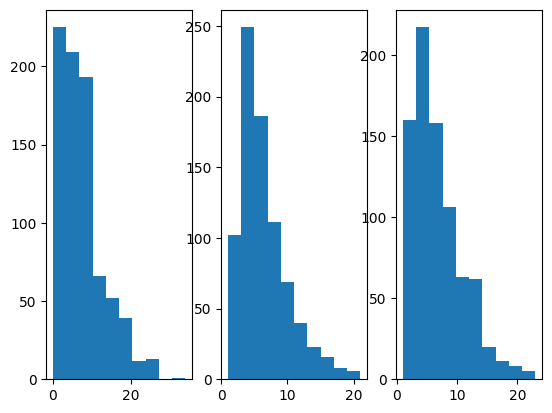

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].hist(automotive_valid['sales'])
axes[1].hist(catboost_pred_frame['sales'])
axes[2].hist(lgb_pred_frame['sales'])

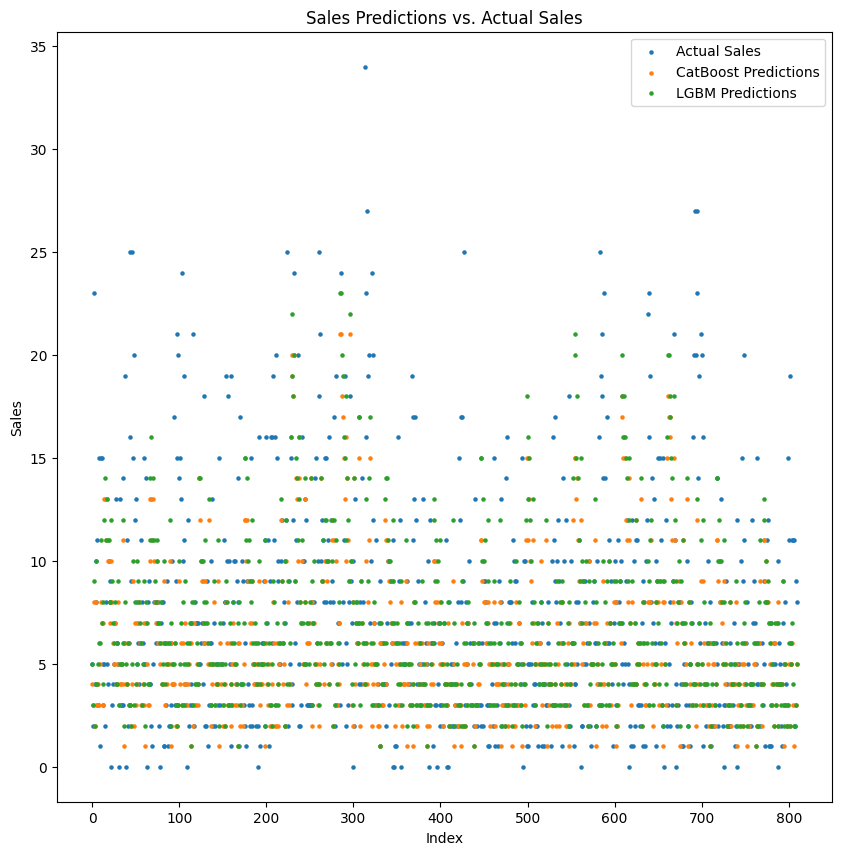

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(range(len(automotive_valid)), automotive_valid['sales'], s=5, label='Actual Sales')
plt.scatter(range(len(automotive_valid)), catboost_pred_frame['sales'], s=5, label='CatBoost Predictions')
plt.scatter(range(len(automotive_valid)), lgb_pred_frame['sales'], s=5, label='LGBM Predictions')

plt.title('Sales Predictions vs. Actual Sales')
plt.xlabel('Index')
plt.ylabel('Sales')

plt.legend()
plt.show()

In [ ]:
import pandas as pd
from catboost import Pool

def normalize_importances(series):
    s = series.copy()
    return 100 * s / s.sum() if s.sum() > 0 else s

def compare_feature_importances(cat_model, lgb_model, X, y):

    pool = Pool(X, y, cat_features=cat_features)
    cat_importance = pd.DataFrame({
        "feature": X.columns,
        "catboost_importance": normalize_importances(
            pd.Series(cat_model.get_feature_importance(pool, type="FeatureImportance"))
        ),
        "catboost_pred_change": normalize_importances(
            pd.Series(cat_model.get_feature_importance(pool, type="PredictionValuesChange"))
        ),
    })


    booster = getattr(lgb_model, "booster_", lgb_model)
    lgb_importance = pd.DataFrame({
        "feature": booster.feature_name(),
        "lgb_gain": normalize_importances(
            pd.Series(booster.feature_importance(importance_type="gain"))
        ),
        "lgb_split": normalize_importances(
            pd.Series(booster.feature_importance(importance_type="split"))
        ),
    })


    df = pd.merge(cat_importance, lgb_importance, on="feature", how="outer").fillna(0)
    df = df.sort_values(by="catboost_importance", ascending=False).reset_index(drop=True)
    return df

df_importances = compare_feature_importances(catboost_model, lgb_model, X_1, y_log)
df_importances


,feature,catboost_importance,catboost_pred_change,lgb_gain,lgb_split
0,transactions,24.01,24.01,18.86,5.46
1,sales_rolling_mean_30,13.78,13.78,26.52,3.03
2,sales_rolling_mean_15,7.77,7.77,22.00,2.32
3,is_weekend,7.66,7.66,3.58,0.51
4,sales_rolling_mean_7,5.05,5.05,4.94,3.28
5,day_of_week,4.30,4.30,1.10,5.12
6,store_cluster,2.44,2.44,1.09,7.55
7,sales_rolling_std_30,2.30,2.30,0.26,2.97
8,store_type,2.12,2.12,0.06,0.34
9,store_city,1.93,1.93,1.43,8.46


lgb better on rmse but catboost understands cats better

lgb is faster


## Baby care

In [ ]:
baby_train = get_family_data(train, 'BABY CARE')
baby_train = baby_train[baby_train['date'] >= '2016-01-01']
baby_valid = get_family_data(valid, 'BABY CARE')

In [ ]:
X_1 = input_func_1(baby_train)

(array([3.1147e+04, 6.3000e+02, 1.5100e+02, 2.5000e+01, 9.0000e+00,
        3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ]),
 <BarContainer object of 10 artists>)

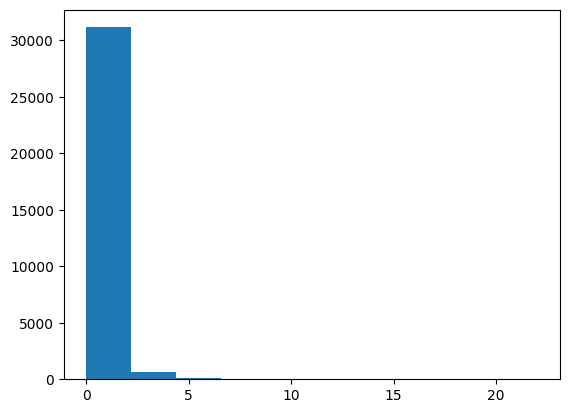

In [ ]:
y = baby_train['sales']
y_log = np.log1p(y)
plt.hist(y)

(array([2.7461e+04, 0.0000e+00, 2.6270e+03, 1.0590e+03, 4.4200e+02,
        2.9100e+02, 6.9000e+01, 1.6000e+01, 2.0000e+00, 1.0000e+00]),
 array([0.        , 0.31354942, 0.62709884, 0.94064826, 1.25419769,
        1.56774711, 1.88129653, 2.19484595, 2.50839537, 2.82194479,
        3.13549422]),
 <BarContainer object of 10 artists>)

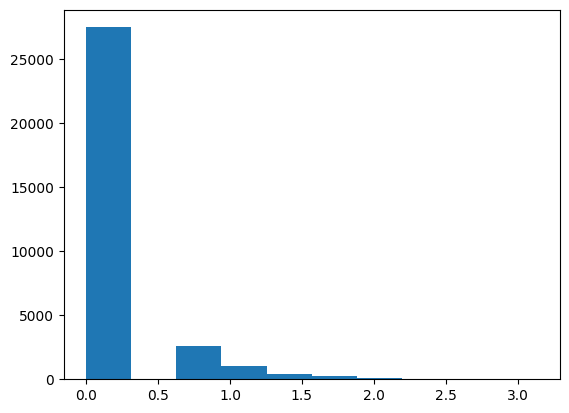

In [ ]:
plt.hist(y_log)

In [ ]:
from catboost import CatBoostRegressor, Pool
from bayes_opt import BayesianOptimization

pbounds = {
    'depth': (4, 10),
    'border_count': (32, 255),
    'iterations': (100, 1000),
    'learning_rate': (0.01, 0.1),
    'l2_leaf_reg': (1, 10),
    'random_strength': (0.0, 8.0),
    'bagging_temperature': (0.0, 1.0),
}


train_pool = Pool(X_1, y_log, cat_features)
def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg, random_strength,
              bagging_temperature):

    iterations = int(iterations)
    depth = int(depth)
    border_count = int(border_count)

    model = CatBoostRegressor(
        depth=depth,
        border_count=border_count,
        iterations=iterations,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        loss_function='RMSE',
        verbose=0,
        # task_type='GPU',
    )

    model.fit(train_pool)
    print('\ntrain score:', model.get_best_score()['learn'])

    families_models.set_family('BABY CARE', model=model, input_func=input_func_1, output_func=output_func_1)
    pred_frame, common_loss = families_models.predict_family(valid, 'BABY CARE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']
print(best_params)


|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | random... | baggin... |
-------------------------------------------------------------------------------------------------------------

train score: {'RMSE': 0.2524331208570953}
| 1         | -0.293040 | 6.2472407 | 244.00929 | 758.79454 | 0.0638792 | 2.4041677 | 1.2479561 | 0.0580836 |

train score: {'RMSE': 0.2885958911553199}
| 2         | -0.294092 | 9.1970568 | 166.04864 | 737.26532 | 0.0118526 | 9.7291886 | 6.6595411 | 0.2123391 |

train score: {'RMSE': 0.28306168457093034}
| 3         | -0.291786 | 5.0909498 | 72.899205 | 373.81801 | 0.0572280 | 4.8875051 | 2.3298331 | 0.6118528 |

train score: {'RMSE': 0.2866030818543626}
| 4         | -0.291651 | 4.8369631 | 97.148256 | 429.72565 | 0.0510462 | 8.0665836 | 1.5973902 | 0.5142344 |

train score: {'RMSE': 0.27867553500467596}
| 5         | -0.291786 | 7.5544874 | 42.358442 | 646.79036 | 0.0253471 | 1.5854643 | 7.5910842 | 0.9656320 |

train score:

KeyboardInterrupt: 

In [ ]:
from catboost import CatBoostRegressor, Pool
from bayes_opt import BayesianOptimization

pbounds = {
    'depth': (4, 10),
    'border_count': (32, 255),
    'iterations': (100, 1000),
    'learning_rate': (0.01, 0.1),
    'l2_leaf_reg': (1, 10),
    'random_strength': (0.0, 8.0),
    'bagging_temperature': (0.0, 1.0),
}


train_pool = Pool(X_1, y + 1, cat_features)
def objective(depth, border_count, iterations, learning_rate, l2_leaf_reg, random_strength,
              bagging_temperature):

    iterations = int(iterations)
    depth = int(depth)
    border_count = int(border_count)

    model = CatBoostRegressor(
        depth=depth,
        border_count=border_count,
        iterations=iterations,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        loss_function='Poisson',
        verbose=0,
        # task_type='GPU',
    )

    model.fit(train_pool)
    print('\ntrain score:', model.get_best_score()['learn'])

    families_models.set_family('BABY CARE', model=model, input_func=input_func_1, output_func=output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'BABY CARE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   depth   | border... | iterat... | learni... | l2_lea... | random... | baggin... |
-------------------------------------------------------------------------------------------------------------

train score: {'Poisson': 0.8808094706117052}
| 1         | -0.328762 | 6.2472407 | 244.00929 | 758.79454 | 0.0638792 | 2.4041677 | 1.2479561 | 0.0580836 |

train score: {'Poisson': 0.9067002924673592}
| 2         | -0.317815 | 9.1970568 | 166.04864 | 737.26532 | 0.0118526 | 9.7291886 | 6.6595411 | 0.2123391 |

train score: {'Poisson': 0.902919724306483}
| 3         | -0.309513 | 5.0909498 | 72.899205 | 373.81801 | 0.0572280 | 4.8875051 | 2.3298331 | 0.6118528 |

train score: {'Poisson': 0.9063045595708541}
| 4         | -0.329726 | 4.8369631 | 97.148256 | 429.72565 | 0.0510462 | 8.0665836 | 1.5973902 | 0.5142344 |

train score: {'Poisson': 0.8996791310908525}
| 5         | -0.311812 | 7.5544874 | 42.358442 | 646.79036 | 0.0253471 | 1.5854643 | 7.5910842 | 0.9656320 |



In [ ]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization

pbounds_lgb = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'num_leaves': (16, 256),
    'min_child_samples': (5, 50),
    'min_child_weight': (1e-3, 10.0),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 255),
    'n_estimators': (500, 2000)
}

def objective(learning_rate, max_depth, num_leaves, min_child_samples,
              min_child_weight, subsample, colsample_bytree,
              reg_alpha, reg_lambda, max_bin, n_estimators):

    train_pool = lgb.Dataset(X_1, label=y + 1, categorical_feature=cat_features)

    max_depth = int(max_depth)
    num_leaves = int(num_leaves)
    min_child_samples = int(min_child_samples)
    max_bin = int(max_bin)
    n_estimators = int(n_estimators)

    params = {
        'objective': 'gamma',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'min_child_samples': min_child_samples,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_bin': max_bin,
        # 'device': 'gpu',
        'verbose': -1
    }

    callbacks = [lgb.log_evaluation(period=n_estimators)]

    model = lgb.train(
        params,
        train_pool,
        num_boost_round=n_estimators,
        valid_sets=[train_pool],
        callbacks=callbacks
    )

    families_models.set_family('BABY CARE', model, input_func_1, output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'BABY CARE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds_lgb,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']
print(best_params)


|   iter    |  target   | learni... | max_depth | num_le... | min_ch... | min_ch... | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[530]	training's gamma: 1.15553
| 1         | -0.322252 | 0.0811626 | 11.605714 | 191.67854 | 31.939631 | 1.5610303 | 0.5779972 | 0.5290418 | 8.6617614 | 6.0111501 | 199.24186 | 530.87674 |
[709]	training's gamma: 1.14237
| 2         | -0.328558 | 0.1942828 | 10.659541 | 66.961386 | 13.182123 | 1.8348616 | 0.6521211 | 0.7623782 | 4.3194501 | 2.9122914 | 180.86390 | 709.24079 |
[597]	training's gamma: 1.15621
| 3         | -0.322968 | 0.0655074 | 6.9308947 | 125.45679 | 40.332918 | 1.9975381 | 0.7571172 | 0.7962072 | 0.4645041 | 6.0754485 | 96.570107 | 597.57738 |
[1863]	training's gamma: 1.13485
| 4         | -0.338296 | 0.1902882 | 11.725056 | 210.01536 | 18.707619 | 0.97762

KeyboardInterrupt: 

{'whiskers': [<matplotlib.lines.Line2D at 0x7cfafd2e57f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7cfafd2e5d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cfafd2e54f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7cfafd2e6210>],
 'fliers': [<matplotlib.lines.Line2D at 0x7cfafd2e64e0>],
 'means': []}

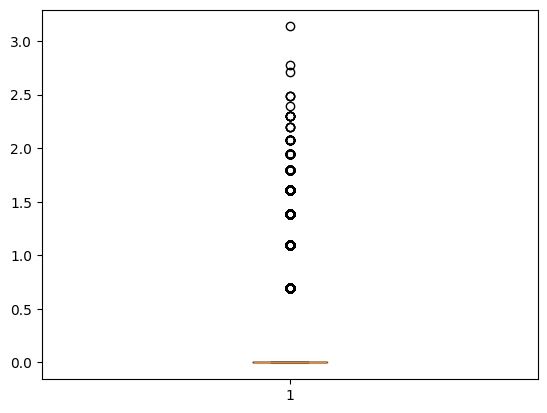

In [ ]:
plt.boxplot(y_log)

In [ ]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import numpy as np


pbounds_lgb = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 12),
    'num_leaves': (16, 256),
    'min_child_samples': (5, 50),
    'min_child_weight': (1e-3, 10.0),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'max_bin': (64, 255),
    'n_estimators': (500, 2000)
}

def objective(learning_rate, max_depth, num_leaves, min_child_samples,
              min_child_weight, subsample, colsample_bytree,
              reg_alpha, reg_lambda, max_bin, n_estimators):

    train_pool = lgb.Dataset(X_1, label=y_log, categorical_feature=cat_features)

    max_depth = int(max_depth)
    num_leaves = int(num_leaves)
    min_child_samples = int(min_child_samples)
    max_bin = int(max_bin)
    n_estimators = int(n_estimators)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'min_child_samples': min_child_samples,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_bin': max_bin,
        # 'device': 'gpu',
        'verbose': -1
    }

    callbacks = [lgb.log_evaluation(period=100)]

    model = lgb.train(
        params,
        train_pool,
        num_boost_round=n_estimators,
        valid_sets=[train_pool],
        callbacks=callbacks
    )

    families_models.set_family('BABY CARE', model, input_func_1, output_func_2)
    pred_frame, common_loss = families_models.predict_family(valid, 'BABY CARE', True, verbose=False)

    return -common_loss

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds_lgb,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=20)

best_params = optimizer.max['params']

|   iter    |  target   | learni... | max_depth | num_le... | min_ch... | min_ch... | subsample | colsam... | reg_alpha | reg_la... |  max_bin  | n_esti... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[100]	training's rmse: 0.502578
[200]	training's rmse: 0.415818
[300]	training's rmse: 0.36084
[400]	training's rmse: 0.326649
[500]	training's rmse: 0.315158
| 1         | -0.342218 | 0.0811626 | 11.605714 | 191.67854 | 31.939631 | 1.5610303 | 0.5779972 | 0.5290418 | 8.6617614 | 6.0111501 | 199.24186 | 530.87674 |
[100]	training's rmse: 0.397738
[200]	training's rmse: 0.307469
[300]	training's rmse: 0.254234
[400]	training's rmse: 0.218713
[500]	training's rmse: 0.192154
[600]	training's rmse: 0.175042
[700]	training's rmse: 0.170545
| 2         | -0.355864 | 0.1942828 | 10.659541 | 66.961386 | 13.182123 | 1.8348616 | 0.6521211 | 0.7623782 | 4.3194501 | 2.9122914 | 180.86390

KeyboardInterrupt: 